# An introduction to machine learning through linear regression

In [1]:
import pandas as pd
import numpy as np
from tqdm.notebook import tqdm

## Input and output data

In [2]:
df = pd.read_csv('../data/life-exp-2014.csv', index_col=0)

In [3]:
df['mortality'] = 100 - df['Life expectancy ']

In [4]:
df.head()

,Country,Year,Status,Life expectancy,Adult Mortality,infant deaths,Alcohol,percentage expenditure,Hepatitis B,Measles,...,GDP,Population,thinness 1-19 years,thinness 5-9 years,Income composition of resources,Schooling,Latitude,Longitude,Num_lang,mortality
1,Afghanistan,2014,Developing,59.9,271.0,64,0.01,73.523582,62.0,492,...,612.696514,26023100.0,17.5,17.5,0.476,10.0,33.00,65.0,3.0,40.1
17,Albania,2014,Developing,77.5,8.0,0,4.51,428.749067,98.0,0,...,4575.763787,2895947.0,1.2,1.3,0.761,14.2,41.00,20.0,1.0,22.5
33,Algeria,2014,Developing,75.4,11.0,21,0.01,54.237318,95.0,0,...,547.851700,38700000.0,6.0,5.8,0.741,14.4,28.00,3.0,1.0,24.6
49,Angola,2014,Developing,51.7,348.0,67,8.33,23.965612,64.0,11699,...,479.312240,24383301.0,8.5,8.3,0.527,11.4,-12.50,18.5,1.0,48.3
65,Antigua and Barbuda,2014,Developing,76.2,131.0,0,8.56,2422.999774,99.0,0,...,12888.296670,86295.0,3.3,3.3,0.782,13.9,17.05,-61.8,1.0,23.8


### Data exploration

In [5]:
import geopandas as geo

In [6]:
import matplotlib.pyplot as plt

In [7]:
target = 'Life expectancy '

In [8]:
countries = geo.read_file(geo.datasets.get_path("naturalearth_lowres"))

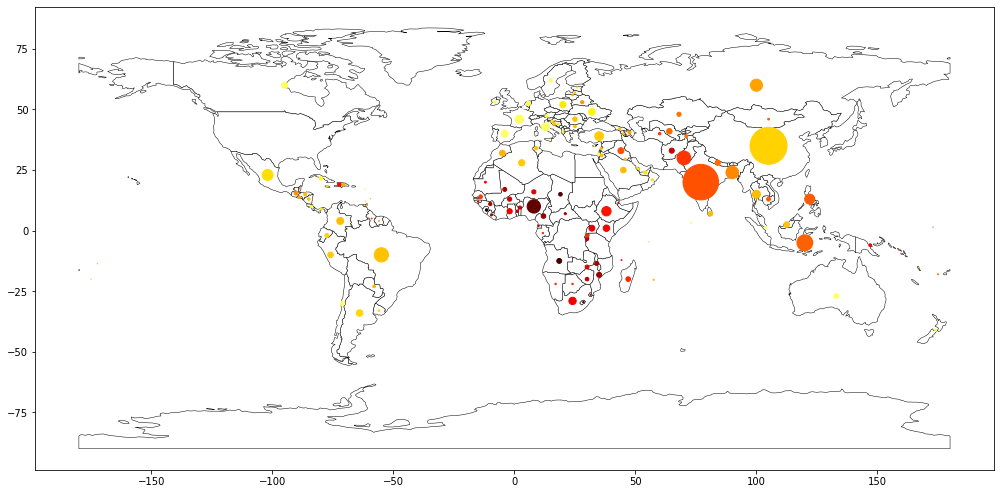

In [10]:
fig, ax = plt.subplots(figsize=(14, 12))
countries.plot(color="white", edgecolor='black', linewidth=.5, ax=ax)
ax.scatter(df.Longitude, df.Latitude, c=df[target], cmap='hot', s=df.Population / 1000000)
plt.tight_layout()
plt.show()

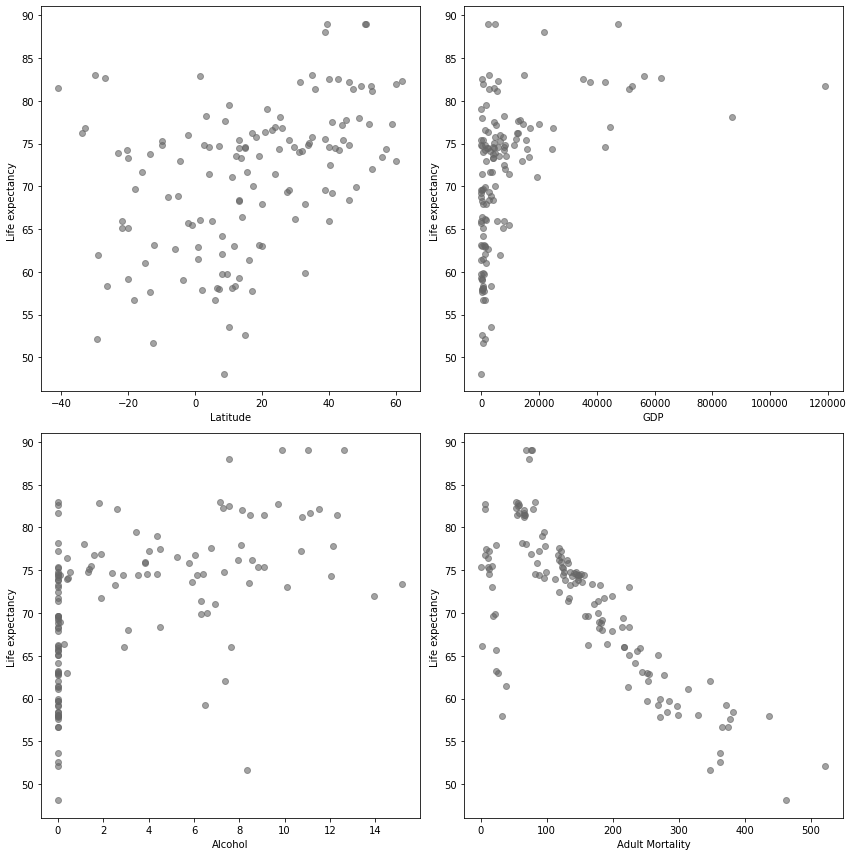

In [11]:
variables = ['Latitude', 'GDP', 'Alcohol', 'Adult Mortality']
fig, ax = plt.subplots(figsize=(12, 12), ncols=2, nrows=2)
for i, v in enumerate(variables):
    a0, a1 = i // 2, i % 2
    sort = df.sort_values(v, ascending=True)
    ax[a0,a1].scatter(sort[v], sort[target], c='#666666', alpha=.6)
    ax[a0,a1].set_xlabel(v)
    ax[a0,a1].set_ylabel(target)
plt.tight_layout()
plt.show()

## Linear regression model prediction

### Simple case: we have just a single variable (aka feature)

$$
\hat{y} = f(x)
$$

Let's try with a simple function having the form

$$
\hat{y} = a x + b
$$

Some examples:

In [12]:
f1 = lambda x: 4*x + 14
f2 = lambda x: 6*x + 12
f3 = lambda x: -0.8*x + 1.2
f4 = lambda x: x**1.5 + 4*x + 2

In [13]:
example = np.linspace(df['Adult Mortality'].min(), df['Adult Mortality'].max())

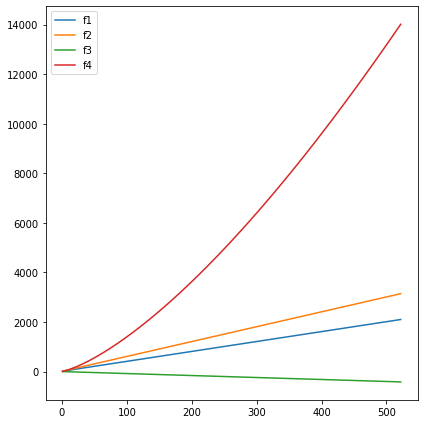

In [14]:
functions = [f1, f2, f3, f4]
fig, ax = plt.subplots(figsize=(6, 6))
for i, f in enumerate(functions):
    ax.plot(example, f(example), label='f{}'.format(i+1))
plt.legend()
plt.tight_layout()
plt.show()

### Let's generalize to multiple features
The general form of the linear regression prediction function is:

$$
\hat{y} = \theta_0 + \theta_1 x_1 + \theta_2 x_2 + \dots + \theta_{n-1} x_{n-1} + \theta_{n} x_{n}
$$

where $\theta_1 \dots \theta_n$ are weights for the features and $\theta_0$ represents a bias term.

Using matrix notation:

$$
\hat{y} = \theta^T \cdot \mathbf{x}
$$

### Back to the prediction problem

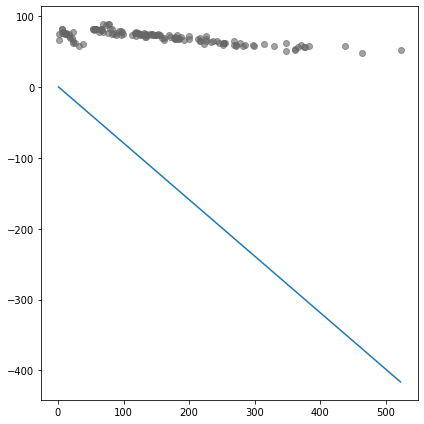

In [15]:
v = 'Adult Mortality'
fig, ax = plt.subplots(figsize=(6, 6))
sort = df.sort_values(v, ascending=True)
ax.scatter(sort[v], sort[target], c='#666666', alpha=.6)
ax.plot(sort[v], f3(sort[v]))
plt.tight_layout()
plt.show()

## Learning the right function

### Compute prodiction error by a loss function

As an example of a loss function, we can use Mean Square Error

$$
MSE(\mathbf{X}, \hat{y}) = \frac{1}{m} \sum\limits_{i=1}^{m} \left( \hat{y}^{(i}) - y^{(i)} \right)^2
$$

In [16]:
prediction = f1(df[v]).values
truth = df[v].values

In [ ]:
((prediction - truth)**2).mean()

### Batch gradient descent
Then, we need the gradient of the loss function in order to use it for updating the parameters in the direction of the $MSE$ minimum. To compute the gradient vector, we start from the partial derivative of each parameter $\theta_j$ as follows:

$$
\frac{\partial}{\partial \theta_j} MSE(\theta) = \frac{2}{m} \sum\limits_{i=1}^{m} \left ( \theta^T \cdot \mathbf{x}^{(i)} - y^{(i)} \right ) x_{j}^{(i)}
$$

That is, in vector form:

$$
grad_{MSE} = \frac{2}{m} \mathbf{X}^T \cdot (\mathbf{X} \cdot \theta - y)
$$

Given $grad_{MSE}$ we just need to subtract it to $\theta$. However, we need to avoid an updating step too big, because we risk to skip the minimum. Thus, let's introduce a learning rate $\eta$ and do training as:

$$
\theta_{i+1} = \theta_i - \eta\ grad_{MSE}(\theta_i)
$$

### Rewrite problem in vector form

In [17]:
X = df[v].values.reshape(-1, 1)
X = X / X.max()
X[:2]

array([[0.51915709],
       [0.01532567]])

add the bias term

In [18]:
Xb = np.c_[np.ones((X.shape[0], 1)), X]
Xb[:2]

array([[1.        , 0.51915709],
       [1.        , 0.01532567]])

### Start with random parameters

In [19]:
theta = np.random.uniform(size=(Xb.shape[1], 1))
theta = np.array([1.2, -0.8]).reshape(-1, 1)
theta

array([[ 1.2],
       [-0.8]])

In [20]:
y = df[target].values.reshape(-1, 1)
y = y / y.max()
y[:2]

array([[0.67303371],
       [0.87078652]])

In [21]:
y_hat_0 = theta.T.dot(Xb[0])
y_hat_0, y[0]

(array([0.78467433]), array([0.67303371]))

In [22]:
y_hat = theta.T.dot(Xb.T)

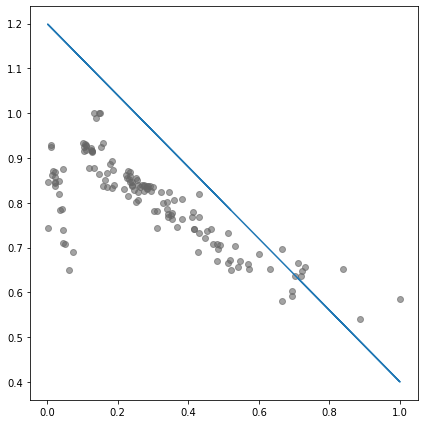

In [23]:
fig, ax = plt.subplots(figsize=(6, 6))
ax.scatter(X, y, c='#666666', alpha=.6)
ax.plot(X, y_hat[0])
plt.tight_layout()
plt.show()

### Learning

In [24]:
mse = lambda theta: np.power(theta.T.dot(Xb.T)[0] - y, 2).mean()

In [25]:
mse(theta)

0.06432067387674399

In [27]:
eta = .01
iterations = 10000
m = Xb.shape[0]

In [28]:
loss = []
history = []
for iteration in range(iterations):
    loss.append(mse(theta))
    gradients = 2/m * Xb.T.dot(Xb.dot(theta) - y)
    theta = theta - eta * gradients
    if iteration % 200 == 0:
        history.append(theta)

In [29]:
theta

array([[ 0.90577829],
       [-0.36058855]])

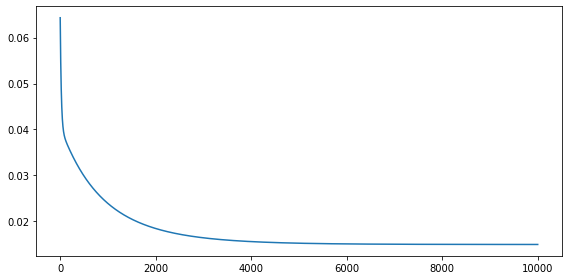

In [30]:
fig, ax = plt.subplots(figsize=(8, 4))
ax.plot(loss)
plt.tight_layout()
plt.show()

In [31]:
y_hat2 = theta.T.dot(Xb.T)

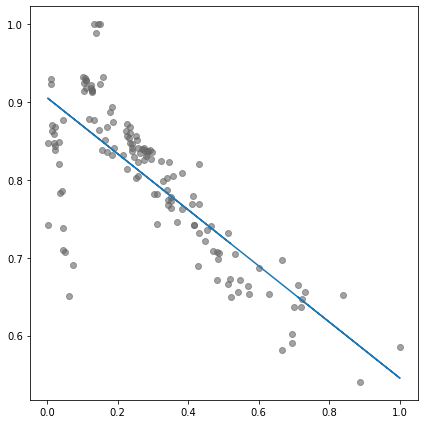

In [32]:
fig, ax = plt.subplots(figsize=(6, 6))
ax.scatter(X, y, c='#666666', alpha=.6)
ax.plot(X, y_hat2[0])
plt.tight_layout()
plt.show()

In [35]:
theta.T.dot(np.array([[1, 0.6]]).T)

array([[0.68942516]])

### Learning progress

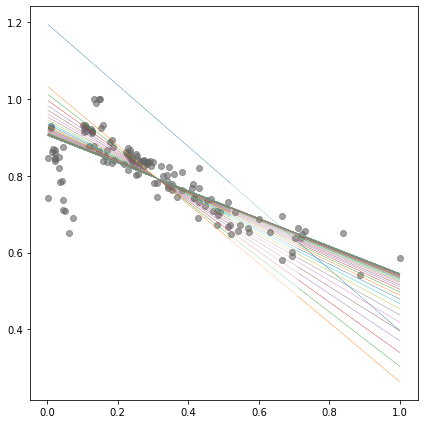

In [36]:
fig, ax = plt.subplots(figsize=(6, 6))
ax.scatter(X, y, c='#666666', alpha=.6)
for th in history:
    y_pred = th.T.dot(Xb.T)
    ax.plot(X, y_pred[0], linewidth=.2)
plt.tight_layout()
plt.show()

In [ ]:
from sklearn.linear_model import LinearRegression

In [ ]:
reg = LinearRegression()

In [ ]:
reg.fit(df[v].values.reshape(-1, 1), df[target].values)

In [ ]:
reg.coef_

In [ ]:
reg.intercept_

In [ ]:
theta

In [ ]:
fig, ax = plt.subplots(figsize=(6, 6))
ax.scatter(df[v], df[target], c='#666666', alpha=.6)
ax.plot(df[v], reg.predict(df[v].values.reshape(-1, 1)))
plt.tight_layout()
plt.show()

## Predict from non linearly correlated data

In [1]:
from IPython.display import Image, display
import ipywidgets as widgets
nn1 = widgets.Image(value=open('../imgs/perceptron.jpg','rb').read(), format='jpg', width='50%')
nn2 = widgets.Image(value=open('../imgs/ffn.jpg','rb').read(), format='jpg', width='50%')
nnb = widgets.HBox([nn1, nn2])
display(nnb)

In [37]:
import torch

In [38]:
x_train = df.GDP.values / df.GDP.values.max()
y_train = df[target].values / df[target].values.max()

In [39]:
X = torch.from_numpy(x_train.astype(np.float32)).view(-1,1)
y = torch.from_numpy(y_train.astype(np.float32)).view(-1,1)

In [40]:
input_size, output_size = 1, 1

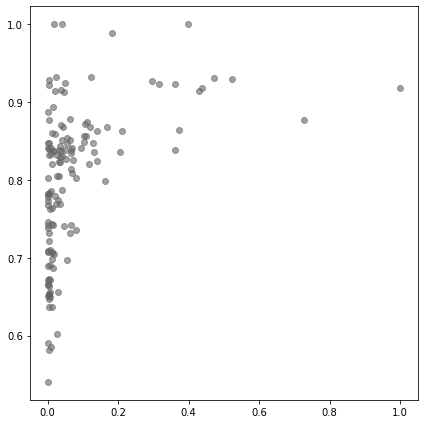

In [41]:
fig, ax = plt.subplots(figsize=(6, 6))
ax.scatter(X, y, c='#666666', alpha=.6)
plt.tight_layout()
plt.show()

In [53]:
from torch.utils.data import TensorDataset, DataLoader

In [54]:
train_dataset = TensorDataset(X, y)
train_dataloader = DataLoader(train_dataset, batch_size=4)

In [55]:
import torch.nn as nn
import torch.nn.functional as F

In [56]:
class SimpleNet(nn.Module):

    def __init__(self, input_size, output_size):
        super(SimpleNet, self).__init__()
        self.fc1 = nn.Linear(input_size, output_size)
        self.a = nn.Tanh()

    def forward(self, x):
        x = self.fc1(x)
        # non linear activation
        x = self.a(x**3)
        return x

In [57]:
net = SimpleNet(input_size, output_size)

In [58]:
for (x, _) in train_dataloader:
    p = net(x)
    break
print(p)

tensor([[0.3359],
        [0.3592],
        [0.3355],
        [0.3351]], grad_fn=<TanhBackward0>)


### Training

In [59]:
learning_rate = 0.01
l = nn.MSELoss()
optimizer = torch.optim.SGD(net.parameters(), lr=learning_rate )

In [60]:
num_epochs = 1000
loss_history = []
for epoch in range(num_epochs):
    y_pred = net(X.requires_grad_())
    loss= l(y_pred, y)
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    loss_history.append(loss.item())

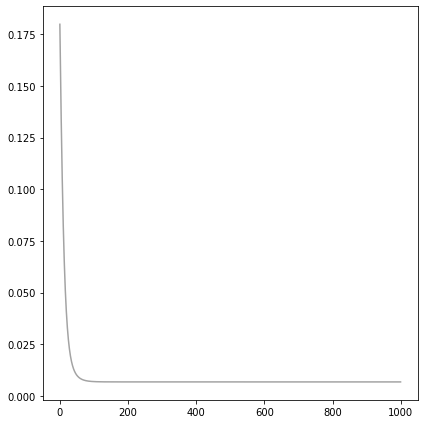

In [61]:
fig, ax = plt.subplots(figsize=(6, 6))
ax.plot(loss_history, c='#666666', alpha=.6)
plt.tight_layout()
plt.show()

In [62]:
predicted = net(X).detach().numpy() 

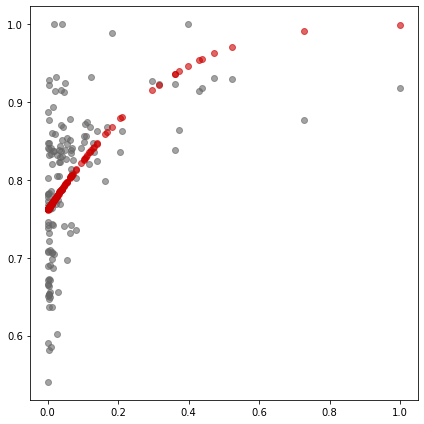

In [63]:
fig, ax = plt.subplots(figsize=(6, 6))
ax.scatter(X.detach(), y.detach().numpy(), c='#666666', alpha=.6)
ax.scatter(X.detach(), predicted, c='#cc0000', alpha=.6)
plt.tight_layout()
plt.show()